# Imports

In [1]:
import pandas
import numpy
import pickle

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, log_loss, matthews_corrcoef
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error

SEED=0

# Load Data

In [2]:
path = '/content/drive/MyDrive/Colab Notebooks/QMIND_2023-2024/'
file_names = {2015: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015_20240223.csv',
              2016: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2016_20240223.csv',
              2017: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2017_20240223.csv',
              2018: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2018_20240223.csv',
              2019: 'Hospital_Inpatient_Discharges__SPARCS_De-Identified___2019_20240203.csv'
             }

columns_to_keep = ['Hospital County', 'Age Group', 'Gender', 'Race', 'Ethnicity', 'Length of Stay',
                   'Type of Admission', 'APR MDC Description', 'APR Severity of Illness Description',
                   'APR Risk of Mortality', 'APR Medical Surgical Description']

df = []
for year, file_name in file_names.items():
    # Load data and only keep relevant columns
    df_temp = pandas.read_csv(path + file_name, low_memory=False)[columns_to_keep]

    # Drop rows with NA/NULL values
    df_temp = df_temp.dropna().reset_index(drop=True)

    # Drop rows with infrequent or unknown values
    df_temp = df_temp[df_temp['Gender'] != 'U']
    df_temp = df_temp[df_temp['Type of Admission'] != 'Not Available']
    df_temp = df_temp[df_temp['APR Medical Surgical Description'] != 'Not Applicable']
    df_temp = df_temp[~df_temp['APR MDC Description'].isin(['PRE MDC', 'Pre-MDC or Ungroupable'])]

    # Drop duplicate rows
    df_temp = df_temp.drop_duplicates(ignore_index=True)

    # Remove rows with length of stay of "120 +"
    df_temp = df_temp[df_temp['Length of Stay'] != '120 +']
    df_temp['Length of Stay'] = df_temp['Length of Stay'].astype(int)

    df.append(df_temp)
    del(df_temp)

df = pandas.concat(df, ignore_index=True)

# Drop duplicate rows
df = df.drop_duplicates(ignore_index=True)

display(df)

<ipython-input-2-0e94d7bd1617>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Length of Stay'] = df_temp['Length of Stay'].astype(int)
<ipython-input-2-0e94d7bd1617>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Length of Stay'] = df_temp['Length of Stay'].astype(int)


,Hospital County,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR MDC Description,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description
0,Allegany,70 or Older,F,White,Not Span/Hispanic,4,Urgent,Diseases and Disorders of the Respiratory System,Moderate,Minor,Medical
1,Allegany,70 or Older,F,White,Not Span/Hispanic,4,Elective,"Endocrine, Nutritional and Metabolic Diseases ...",Moderate,Moderate,Medical
2,Allegany,70 or Older,F,White,Not Span/Hispanic,4,Urgent,Diseases and Disorders of the Respiratory System,Minor,Minor,Medical
3,Allegany,50 to 69,F,White,Not Span/Hispanic,2,Elective,Diseases and Disorders of the Digestive System,Moderate,Minor,Medical
4,Allegany,70 or Older,M,White,Not Span/Hispanic,2,Elective,Diseases and Disorders of the Respiratory System,Minor,Moderate,Medical
...,...,...,...,...,...,...,...,...,...,...,...
3015951,Clinton,30 to 49,F,White,Not Span/Hispanic,5,Urgent,"INJURIES, POISONINGS AND TOXIC EFFECTS OF DRUGS",Moderate,Minor,Medical
3015952,Queens,50 to 69,M,Other Race,Not Span/Hispanic,5,Urgent,INFECTIOUS AND PARASITIC DISEASES (SYSTEMIC OR...,Moderate,Moderate,Medical
3015953,Kings,30 to 49,M,White,Spanish/Hispanic,5,Emergency,DISEASES AND DISORDERS OF THE NERVOUS SYSTEM,Major,Major,Medical
3015954,Kings,30 to 49,F,Black/African American,Not Span/Hispanic,18,Emergency,DISEASES AND DISORDERS OF THE CIRCULATORY SYSTEM,Major,Minor,Medical


# Data Exploration

In [3]:
# Fix inconsistencies in description column
df['APR MDC Description'] = df['APR MDC Description'].str.lower()
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'infectious and parasitic diseases, systemic or unspecified sites',
                                        'infectious and parasitic diseases (systemic or unspecified sites)', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'factors influencing health status and other contacts with health services',
                                        'rehabilitation, aftercare, other factors influencing health status and other health service contacts', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'diseases and disorders of the musculoskeletal system and conn tissue',
                                        'diseases and disorders of the musculoskeletal system and connective tissue', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'diseases and disorders of the ear, nose, mouth and throat',
                                        'ear, nose, mouth, throat and craniofacial diseases and disorders', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'diseases and disorders of blood, blood forming organs and immunological disorders',
                                        'diseases and disorders of the blood and blood forming organs and immunological disorders', df['APR MDC Description'])
df['APR MDC Description'] = numpy.where(df['APR MDC Description'] == 'injuries, poisonings and toxic effects of drugs',
                                        'poisonings, toxic effects, other injuries and other complications of treatment', df['APR MDC Description'])

In [4]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015956 entries, 0 to 3015955
Data columns (total 11 columns):
 #   Column                               Non-Null Count    Dtype 
---  ------                               --------------    ----- 
 0   Hospital County                      3015956 non-null  object
 1   Age Group                            3015956 non-null  object
 2   Gender                               3015956 non-null  object
 3   Race                                 3015956 non-null  object
 4   Ethnicity                            3015956 non-null  object
 5   Length of Stay                       3015956 non-null  int64 
 6   Type of Admission                    3015956 non-null  object
 7   APR MDC Description                  3015956 non-null  object
 8   APR Severity of Illness Description  3015956 non-null  object
 9   APR Risk of Mortality                3015956 non-null  object
 10  APR Medical Surgical Description     3015956 non-null  object
dtypes: int64(1)

In [5]:
df.describe(include='all')

,Hospital County,Age Group,Gender,Race,Ethnicity,Length of Stay,Type of Admission,APR MDC Description,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description
count,3015956,3015956,3015956,3015956,3015956,3.015956e+06,3015956,3015956,3015956,3015956,3015956
unique,57,5,2,4,4,NaN,5,26,4,4,2
top,Manhattan,50 to 69,F,White,Not Span/Hispanic,NaN,Emergency,diseases and disorders of the circulatory system,Moderate,Minor,Medical
freq,448617,982775,1513591,1535294,2230212,NaN,2048926,327086,1027356,1183073,2089483
mean,NaN,NaN,NaN,NaN,NaN,9.393594e+00,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,1.180352e+01,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,3.000000e+00,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,6.000000e+00,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,1.100000e+01,NaN,NaN,NaN,NaN,NaN


In [6]:
for column in df.columns:
    print(column)
    print(df[column].value_counts(dropna=False))
    print()

Hospital County
Manhattan      448617
Kings          246281
Bronx          235208
Queens         218555
Nassau         192764
Westchester    172858
Suffolk        162967
Monroe         144248
Erie           140072
Onondaga       107755
Albany         107608
Richmond        81208
Orange          69624
Dutchess        52839
Rockland        50897
Oneida          46419
Broome          45693
Schenectady     35654
Chemung         27848
Otsego          27792
Niagara         26631
Warren          21590
Rensselaer      21444
Ontario         21437
Ulster          20914
St Lawrence     20716
Jefferson       19778
Chautauqua      18997
Saratoga        17570
Clinton         17258
Tompkins        15430
Montgomery      14676
Columbia        14391
Putnam          13233
Wayne           12069
Cattaraugus     11463
Sullivan        11050
Franklin        10237
Cayuga          10077
Steuben          9836
Oswego           9411
Genesee          9128
Cortland         7875
Madison          7329
Fulton          

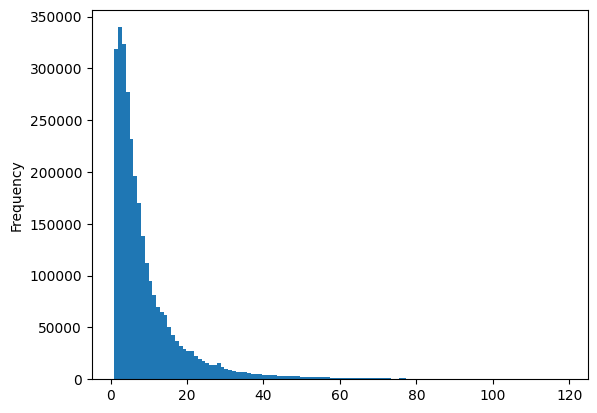

In [7]:
# Plot length of stay
df[df['Length of Stay'] != '120 +']['Length of Stay'].astype(int).plot.hist(bins=119);

# Data Preparation/Processing

In [8]:
# Combine length of stay into multi-class categories (v1)
target_classes_multiclass_v1 = ['1-4 days', '5-9 days', '10-119 days']
lim_1 = 5
lim_2 = 10
df['Length of Stay - Multi-class v1'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim_1))), 1, df['Length of Stay'])
df['Length of Stay - Multi-class v1'] = numpy.where(df['Length of Stay - Multi-class v1'].isin(list(range(lim_1, lim_2))), 2, df['Length of Stay - Multi-class v1'])
df['Length of Stay - Multi-class v1'] = numpy.where(df['Length of Stay - Multi-class v1'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim_2)))), 3, df['Length of Stay - Multi-class v1'])
df['Length of Stay - Multi-class v1'].value_counts()

1    1259615
3     907500
2     848841
Name: Length of Stay - Multi-class v1, dtype: int64

In [9]:
# Combine length of stay into multi-class categories (v2)
target_classes_multiclass_v2 = ['1-6 days', '7-14 days', '15-119 days']
lim_1 = 7
lim_2 = 15
df['Length of Stay - Multi-class v2'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim_1))), 1, df['Length of Stay'])
df['Length of Stay - Multi-class v2'] = numpy.where(df['Length of Stay - Multi-class v2'].isin(list(range(lim_1, lim_2))), 2, df['Length of Stay - Multi-class v2'])
df['Length of Stay - Multi-class v2'] = numpy.where(df['Length of Stay - Multi-class v2'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim_2)))), 3, df['Length of Stay - Multi-class v2'])
df['Length of Stay - Multi-class v2'].value_counts()

1    1687696
2     794389
3     533871
Name: Length of Stay - Multi-class v2, dtype: int64

In [10]:
# Combine length of stay into binary categories (v1)
target_classes_binary_v1 = ['1-7 days', '8-119 days']
lim = 8
df['Length of Stay - Binary v1'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim))), 0, df['Length of Stay'])
df['Length of Stay - Binary v1'] = numpy.where(df['Length of Stay - Binary v1'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim)))), 1, df['Length of Stay - Binary v1'])
df['Length of Stay - Binary v1'].value_counts()

0    1857669
1    1158287
Name: Length of Stay - Binary v1, dtype: int64

In [11]:
# Combine length of stay into binary categories (v2)
target_classes_binary_v2 = ['1-9 days', '10-119 days']
lim = 10
df['Length of Stay - Binary v2'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim))), 0, df['Length of Stay'])
df['Length of Stay - Binary v2'] = numpy.where(df['Length of Stay - Binary v2'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim)))), 1, df['Length of Stay - Binary v2'])
df['Length of Stay - Binary v2'].value_counts()

0    2108456
1     907500
Name: Length of Stay - Binary v2, dtype: int64

In [12]:
# Combine length of stay into binary categories (v3)
target_classes_binary_v3 = ['1-10 days', '11-119 days']
lim = 11
df['Length of Stay - Binary v3'] = numpy.where(df['Length of Stay'].isin(list(range(1, lim))), 0, df['Length of Stay'])
df['Length of Stay - Binary v3'] = numpy.where(df['Length of Stay - Binary v3'].isin(numpy.setdiff1d(numpy.unique(df['Length of Stay']), list(range(1, lim)))), 1, df['Length of Stay - Binary v3'])
df['Length of Stay - Binary v3'].value_counts()

0    2203727
1     812229
Name: Length of Stay - Binary v3, dtype: int64

In [13]:
# Split into training and testing subsets
X = df.drop(columns=['Length of Stay', 'Length of Stay - Multi-class v1', 'Length of Stay - Multi-class v2', 'Length of Stay - Binary v1', 'Length of Stay - Binary v2', 'Length of Stay - Binary v3'])
y_multiclass_v1 = df['Length of Stay - Multi-class v1']
y_multiclass_v2 = df['Length of Stay - Multi-class v2']
y_binary_v1 = df['Length of Stay - Binary v1']
y_binary_v2 = df['Length of Stay - Binary v2']
y_binary_v3 = df['Length of Stay - Binary v3']
y_regression = df['Length of Stay']
X_train, X_test, y_multiclass_v1_train, y_multiclass_v1_test, y_multiclass_v2_train, y_multiclass_v2_test, y_binary_v1_train, y_binary_v1_test, y_binary_v2_train, y_binary_v2_test, y_binary_v3_train, y_binary_v3_test, y_regression_train, y_regression_test = train_test_split(X, y_multiclass_v1, y_multiclass_v2, y_binary_v1, y_binary_v2, y_binary_v3, y_regression, test_size=0.2, random_state=0, stratify=y_regression)
print('Training:', len(X_train))
print('Testing:', len(X_test))

Training: 2412764
Testing: 603192


In [14]:
# One-hot encode categorical features

for column in X_train.columns:
    for value in numpy.unique(df[column]):
        X_train[column + ' - ' + value] = numpy.where(X_train[column] == value, 1, 0)
        X_test[column + ' - ' + value] = numpy.where(X_test[column] == value, 1, 0)

# Drop original columns
X_train = X_train.drop(columns=df.drop(columns=['Length of Stay', 'Length of Stay - Multi-class v1', 'Length of Stay - Multi-class v2', 'Length of Stay - Binary v1', 'Length of Stay - Binary v2', 'Length of Stay - Binary v3']).columns)
X_test = X_test.drop(columns=df.drop(columns=['Length of Stay', 'Length of Stay - Multi-class v1', 'Length of Stay - Multi-class v2', 'Length of Stay - Binary v1', 'Length of Stay - Binary v2', 'Length of Stay - Binary v3']).columns)

# Print number of columns after one-hot encoding
print('Number of columns after one-hot encoding:', X_train.shape[1])

<ipython-input-14-290977ea6e3e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[column + ' - ' + value] = numpy.where(X_train[column] == value, 1, 0)
<ipython-input-14-290977ea6e3e>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[column + ' - ' + value] = numpy.where(X_test[column] == value, 1, 0)
<ipython-input-14-290977ea6e3e>:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

Number of columns after one-hot encoding: 113


In [15]:
print('Number of columns after one-hot encoding:', X_train.shape[1])

Number of columns after one-hot encoding: 113


# Training and Testing Functions

In [16]:
def train_and_test_classification(y_train, y_test, mode, target_names):
    models = {'BernoulliNB': BernoulliNB(), 'MLPClassifier': MLPClassifier(max_iter=500, random_state=SEED)}
    # models = {'BernoulliNB': BernoulliNB(), 'LogisticRegression': LogisticRegression(max_iter=500, random_state=SEED),
    #           'MLPClassifier': MLPClassifier(max_iter=500, random_state=SEED), 'DecisionTreeClassifier': DecisionTreeClassifier(random_state=SEED),
    #           'RandomForestClassifier': RandomForestClassifier(random_state=SEED)
    #           }

    for model_name, model in models.items():
        print(model_name)

        # Training
        model = model.fit(X_train, y_train)

        # Testing
        classifications = model.predict(X_test)
        probabilities = model.predict_proba(X_test)

        # Evaluation
        print(confusion_matrix(y_test, classifications))
        print()
        print(classification_report(y_test, classifications, target_names=target_names))
        print('Accuracy: ', round(accuracy_score(y_test, classifications), 4))
        if mode == 'Multi-Class':
            print('Recall:   ', round(recall_score(y_test, classifications, average='macro'), 4))
            print('Precision:', round(precision_score(y_test, classifications, average='macro'), 4))
            print('F1:       ', round(f1_score(y_test, classifications, average='macro'), 4))
            print('AU_ROC:   ', round(roc_auc_score(y_test, probabilities, multi_class='ovr'), 4))
            print('Log loss: ', round(log_loss(y_test, probabilities), 4))
        elif mode == 'Binary':
            print('Recall:   ', round(recall_score(y_test, classifications), 4))
            print('Precision:', round(precision_score(y_test, classifications), 4))
            print('F1:       ', round(f1_score(y_test, classifications), 4))
            print('AU_ROC:   ', round(roc_auc_score(y_test, probabilities[:,1]), 4))
            print('Log loss: ', round(log_loss(y_test, probabilities[:,1]), 4))
        print('MCC:      ', round(matthews_corrcoef(y_test, classifications), 4))

        print()

    return models

In [17]:
def train_and_test_regression(y_train, y_test):
    models = {'MLPRegressor': MLPRegressor(max_iter=500, random_state=SEED)}
    # models = {'LinearRegression': LinearRegression(), 'MLPRegressor': MLPRegressor(max_iter=500, random_state=SEED),
    #           'DecisionTreeRegressor': DecisionTreeRegressor(random_state=SEED), 'RandomForestRegressor': RandomForestRegressor(random_state=SEED)}

    for model_name, model in models.items():
        print(model_name)

        # To ensure positive: https://stackoverflow.com/questions/26897981/restrict-the-predictions-from-sgdregressor-in-scikit-learn-to-positive-values

        # Training
        model = model.fit(X_train, numpy.log(y_train))

        # Testing
        predictions = numpy.round(numpy.exp(model.predict(X_test)))

        # Evaluation (regression)
        print('R2:                         ', round(r2_score(y_test, predictions), 4))
        print('Mean absolute error:        ', round(mean_absolute_error(y_test, predictions), 4))
        print('Median absolute error:      ', round(median_absolute_error(y_test, predictions), 4))
        print('Mean squared error:         ', round(mean_squared_error(y_test, predictions), 4))
        print('Root mean squared error:    ', round(mean_squared_error(y_test, predictions, squared=False), 4))
        print('Mean squared log error:     ', round(mean_squared_log_error(y_test, predictions), 4))
        print('Root mean squared log error:', round(mean_squared_log_error(y_test, predictions, squared=False), 4))

        # Evaluation (classification)
        print('Accuracy:                   ', round(accuracy_score(y_test, predictions), 4))
        print('Recall:                     ', round(recall_score(y_test, predictions, average='macro'), 4))
        print('Precision:                  ', round(precision_score(y_test, predictions, average='macro'), 4))
        print('F1:                         ', round(f1_score(y_test, predictions, average='macro'), 4))
        print('MCC:                        ', round(matthews_corrcoef(y_test, predictions), 4))

        print()

    return models

# Training and Testing (Multiclass)

In [ ]:
models_multiclass_v1 = train_and_test_classification(y_multiclass_v1_train, y_multiclass_v1_test, 'Multi-Class', target_classes_multiclass_v1)

In [19]:
models_multiclass_v2 = train_and_test_classification(y_multiclass_v2_train, y_multiclass_v2_test, 'Multi-Class', target_classes_multiclass_v2)

BernoulliNB
[[260617  51604  25320]
 [ 84705  44346  29828]
 [ 38132  25978  42662]]

              precision    recall  f1-score   support

    1-6 days       0.68      0.77      0.72    337541
   7-14 days       0.36      0.28      0.32    158879
 15-119 days       0.44      0.40      0.42    106772

    accuracy                           0.58    603192
   macro avg       0.49      0.48      0.49    603192
weighted avg       0.55      0.58      0.56    603192

Accuracy:  0.5763
Recall:    0.4836
Precision: 0.4932
F1:        0.4853
AU_ROC:    0.7046
Log loss:  0.9437
MCC:       0.249

MLPClassifier
[[289431  24505  23605]
 [ 94034  30854  33991]
 [ 27773  18490  60509]]

              precision    recall  f1-score   support

    1-6 days       0.70      0.86      0.77    337541
   7-14 days       0.42      0.19      0.27    158879
 15-119 days       0.51      0.57      0.54    106772

    accuracy                           0.63    603192
   macro avg       0.54      0.54      0.53    

# Training and Testing (Binary)

In [ ]:
models_binary_v1 = train_and_test_classification(y_binary_v1_train, y_binary_v1_test, 'Binary', target_classes_binary_v1)

In [ ]:
models_binary_v2 = train_and_test_classification(y_binary_v2_train, y_binary_v2_test, 'Binary', target_classes_binary_v2)

In [18]:
models_binary_v3 = train_and_test_classification(y_binary_v3_train, y_binary_v3_test, 'Binary', target_classes_binary_v3)

BernoulliNB
[[374240  66508]
 [ 88868  73576]]

              precision    recall  f1-score   support

   1-10 days       0.81      0.85      0.83    440748
 11-119 days       0.53      0.45      0.49    162444

    accuracy                           0.74    603192
   macro avg       0.67      0.65      0.66    603192
weighted avg       0.73      0.74      0.74    603192

Accuracy:  0.7424
Recall:    0.4529
Precision: 0.5252
F1:        0.4864
AU_ROC:    0.75
Log loss:  0.5504
MCC:       0.3173

MLPClassifier
[[399170  41578]
 [ 84512  77932]]

              precision    recall  f1-score   support

   1-10 days       0.83      0.91      0.86    440748
 11-119 days       0.65      0.48      0.55    162444

    accuracy                           0.79    603192
   macro avg       0.74      0.69      0.71    603192
weighted avg       0.78      0.79      0.78    603192

Accuracy:  0.791
Recall:    0.4797
Precision: 0.6521
F1:        0.5528
AU_ROC:    0.8323
Log loss:  0.4331
MCC:       0.428

# Training and Testing (Regression)

In [20]:
models_regression = train_and_test_regression(y_regression_train, y_regression_test)

MLPRegressor
R2:                          0.2519
Mean absolute error:         5.3445
Median absolute error:       3.0
Mean squared error:          104.2125
Root mean squared error:     10.2085
Mean squared log error:      0.4442
Root mean squared log error: 0.6665
Accuracy:                    0.1082


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall:                      0.0137


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:                   0.0199
F1:                          0.0129
MCC:                         0.0444

